In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [66]:
"""Plot SPM results: wavelength/frequency vs fiber position with power colormap"""

# Read data from database
data = pd.read_sql("SELECT * FROM spm_results", "sqlite:///data/spm_results.db")

In [67]:

# Get unique z positions and time points
z_positions = data['z_position'].unique()
time_points = data['time_point'].unique()

print(f"Data shape: {len(z_positions)} z-positions, {len(time_points)} time points")

# Create 2D arrays for plotting
n_z = len(z_positions)
n_t = len(time_points)

# Speed of light in vacuum (m/s)
c = 299792458.0
# Central wavelength (m) - from the simulation
lambda_0 = 1550e-9

# Prepare data structures
power_spectrum = np.zeros((n_z, n_t))

# For each z position, compute FFT to get frequency spectrum
for i, z in enumerate(z_positions):
    # Get data for this z position
    z_data = data[data['z_position'] == z].sort_values('time_point')
    
    # Extract complex amplitude
    A_real = z_data['amplitude_real'].values
    A_imag = z_data['amplitude_imag'].values
    A_complex = A_real + 1j * A_imag
    
    # Compute FFT to get frequency domain
    A_freq = fft(A_complex)
    power_freq = np.abs(A_freq)**2
    
    # Store power spectrum
    power_spectrum[i, :] = np.fft.fftshift(power_freq)

# Compute frequency axis
dt = time_points[1] - time_points[0]
frequencies = fftfreq(n_t, dt)
frequencies_shifted = np.fft.fftshift(frequencies)

# Convert frequencies to wavelengths (in nm)
f_0 = c / lambda_0
wavelengths_nm = c / (f_0 + frequencies_shifted) * 1e9

# Clip wavelengths to reasonable range around central wavelength
valid_indices = (wavelengths_nm > 1400) & (wavelengths_nm < 1700)
wavelengths_plot = wavelengths_nm[valid_indices]
power_spectrum_plot = power_spectrum[:, valid_indices]


Data shape: 1002 z-positions, 512 time points



Plot saved to: data/spm_spectral_evolution.png


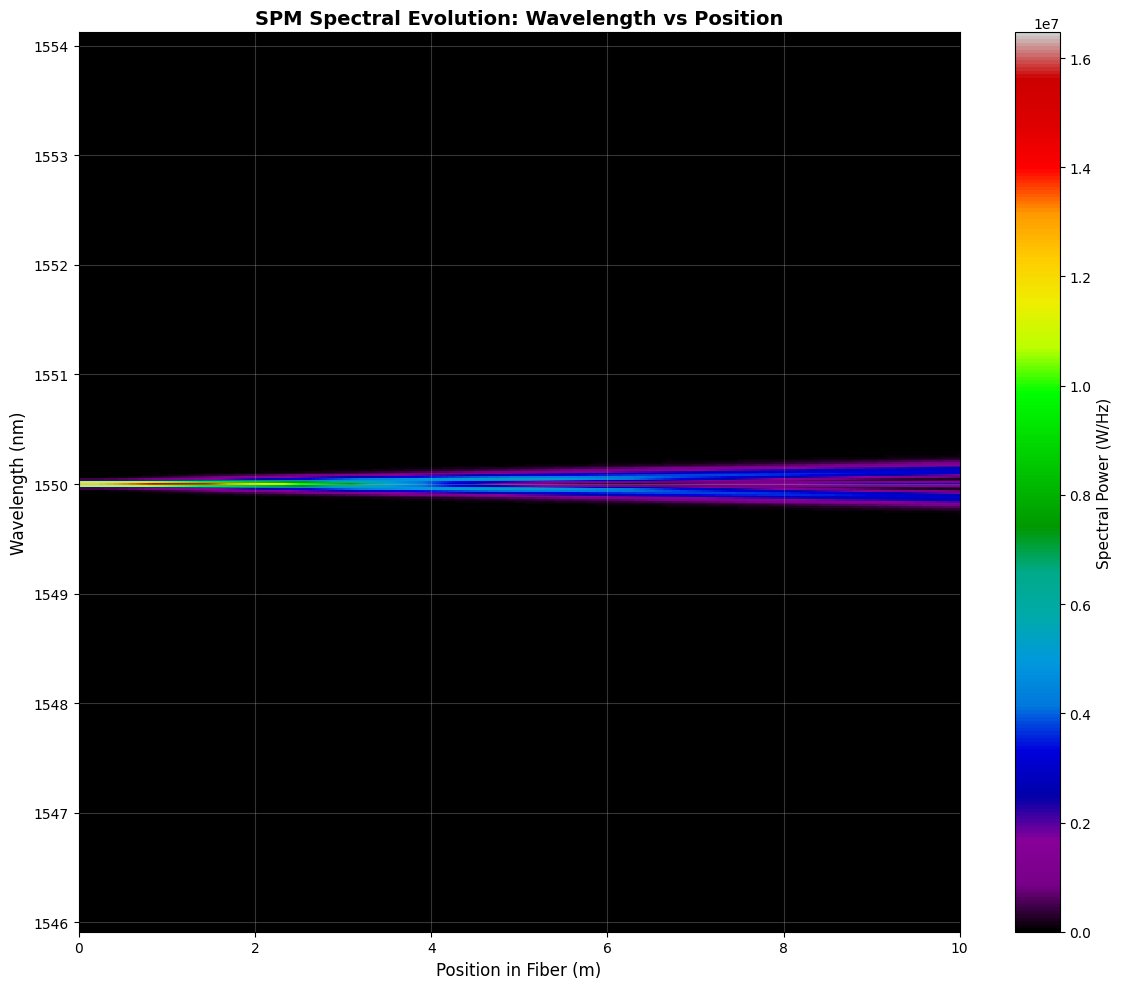

In [68]:

# Create figure with 2D colormap
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot 1: 2D heatmap - Position vs Wavelength with Power colorbar
im1 = ax1.pcolormesh(z_positions, wavelengths_plot, power_spectrum_plot.T,
                        shading='auto', cmap='nipy_spectral')
ax1.set_xlabel('Position in Fiber (m)', fontsize=12)
ax1.set_ylabel('Wavelength (nm)', fontsize=12)
ax1.set_title('SPM Spectral Evolution: Wavelength vs Position', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Spectral Power (W/Hz)', fontsize=11)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/spm_spectral_evolution.png', dpi=300, bbox_inches='tight')
print("\nPlot saved to: data/spm_spectral_evolution.png")
plt.show()


Plot saved to: data/spm_spectral_comparison.png


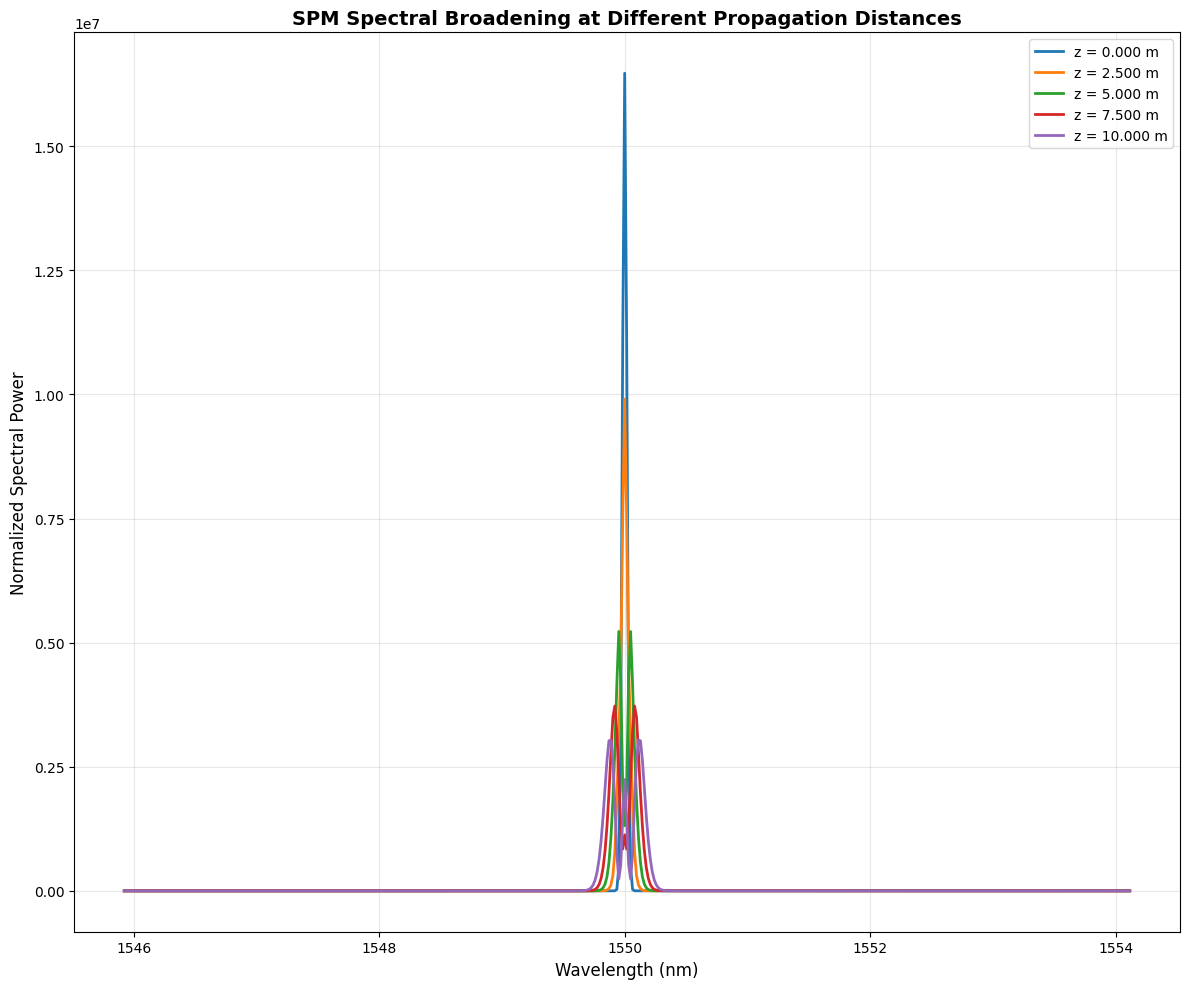

In [69]:

# Additional plot: Spectrum at different positions
fig2, ax3 = plt.subplots(figsize=(12, 10))

# Plot spectra at 5 different positions
z_indices = np.linspace(0, n_z-1, 5, dtype=int)
for idx in z_indices:
    z_val = z_positions[idx]
    spectrum = power_spectrum_plot[idx, :]
    ax3.plot(wavelengths_plot, spectrum, 
            label=f'z = {z_val:.3f} m', linewidth=2)

ax3.set_xlabel('Wavelength (nm)', fontsize=12)
ax3.set_ylabel('Normalized Spectral Power', fontsize=12)
ax3.set_title('SPM Spectral Broadening at Different Propagation Distances', 
                fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/spm_spectral_comparison.png', dpi=300, bbox_inches='tight')
print("Plot saved to: data/spm_spectral_comparison.png")
plt.show()


Plot saved to: data/spm_temporal_evolution.png


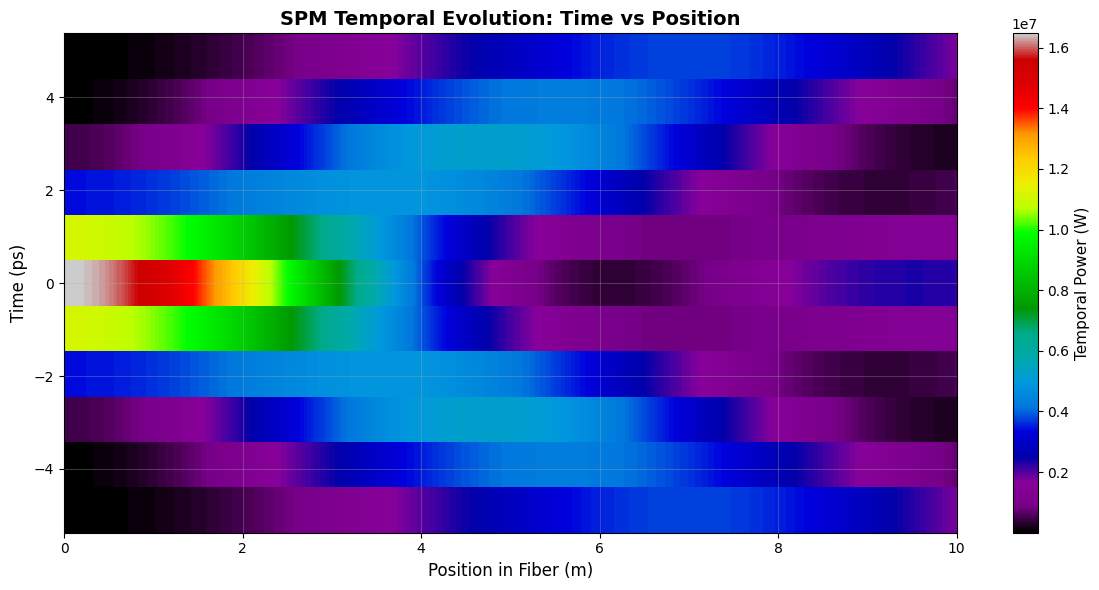

In [71]:
# Time vs Position Plot for time domain representation
fig3, ax4 = plt.subplots(figsize=(12, 6))
# Plot 3 for the time domain representation
valid_time_indices = (time_points > -5e-12) & (time_points < 5e-12)
wavelength_time_plot = time_points[valid_time_indices] * 1e12  # Convert to ps
power_time_plot = power_spectrum[:, valid_time_indices]

im2 = ax4.pcolormesh(z_positions, wavelength_time_plot, power_time_plot.T,
                        shading='auto', cmap='nipy_spectral')
ax4.set_xlabel('Position in Fiber (m)', fontsize=12)
ax4.set_ylabel('Time (ps)', fontsize=12)
ax4.set_title('SPM Temporal Evolution: Time vs Position', fontsize=14, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=ax4)
cbar2.set_label('Temporal Power (W)', fontsize=11)
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/spm_temporal_evolution.png', dpi=300, bbox_inches='tight')
print("Plot saved to: data/spm_temporal_evolution.png")
plt.show()